# Evaluating variation in model predictions and predicted 10k thrombolysis rate using bootstrap models

Here we evaluate the variation in model predictions (at a patient level) and predicted 10k thrombolysis rate using bootstrap models.

We apply two bootstrap methods, In the traditional method we fit multiple models to bootstrapped samples of the trainign set (random sampling with replacement).

In the Bayesian bootstrap method we fit multiple models, with the training set weighted each time by sampling from a Drichlet distibution (see https://towardsdatascience.com/the-bayesian-bootstrap-6ca4a1d45148).

These methods give similar results - the average standard deviation in patient-level prediction (the probability of a patient receiving thrombolysis) is about 0.05. The average standard deviation in predicting the hospital's expected thrombolysis rate is 0.015-0.02.

In [1]:
# Turn warnings off to keep notebook tidy
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np

from scipy import stats

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.linear_model import LinearRegression

from xgboost import XGBClassifier
import json

## Create bootstrap sampled training sets using standard bootstrapping

## Read in JSON file

Contains a dictionary for plain English feature names for the 8 features selected in the model. Use these as the column titles in the DataFrame.

In [2]:
with open("./output/feature_name_dict.json") as json_file:
    feature_name_dict = json.load(json_file)

## Load data

10k cohort of patients in test data, rest in training data

In [3]:
data_loc = '../data/10k_training_test/'

In [4]:
# Load data
train = pd.read_csv(data_loc + 'cohort_10000_train.csv')
test = pd.read_csv(data_loc + 'cohort_10000_test.csv')

# Read in the names of the selected features for the model
number_of_features_to_use = 8
key_features = pd.read_csv('./output/feature_selection.csv')
key_features = list(key_features['feature'])[:number_of_features_to_use]
# And add the target feature name: S2Thrombolysis
key_features.append('S2Thrombolysis')

# Select features
train = train[key_features]
train.rename(columns=feature_name_dict, inplace=True)
test = test[key_features]
test.rename(columns=feature_name_dict, inplace=True)

## Train model using normal (non boots-strapping) method

In [5]:
# Get X and y
X_train = train.drop('Thrombolysis', axis=1)
X_test = test.drop('Thrombolysis', axis=1)
y_train = train['Thrombolysis']
y_test = test['Thrombolysis']

# One hot encode hospitals
X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
X_train = pd.concat([X_train, X_train_hosp], axis=1)
X_train.drop('Stroke team', axis=1, inplace=True)
X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
X_test = pd.concat([X_test, X_test_hosp], axis=1)
X_test.drop('Stroke team', axis=1, inplace=True)  

# Define and fit model
model = XGBClassifier(verbosity=0, seed=42, learning_rate=0.5)
model.fit(X_train, y_train)

# Get predicted probabilities and class
y_probs = model.predict_proba(X_test)[:,1]
y_pred = y_probs > 0.5

# Show accuracy
accuracy = np.mean(y_pred == y_test)
print (f'Accuracy: {accuracy:.3f}')

Accuracy: 0.841


### Pass 10k cohort through all hospital models and get thrombolysis rate

For each hospital, set all of the 10k patients in the test set as attending that hospital, and calculate the thrombolysis rate. This will give a thrombolysis rate for each hospital with patient variation removed, and only hospital factors remaining.

In [6]:
# Get list of hopsitals
hospitals = list(set(train['Stroke team']))
hospitals.sort()
single_fit_thrombolysis_10k_rate = []

for hospital in hospitals:

    # Get test data without thrombolysis hospital or stroke team
    X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)

    # Copy hospital dataframe and change hospital ID (after setting all to zero)
    X_test_adjusted_hospital = X_test_hosp.copy()
    X_test_adjusted_hospital.loc[:,:] = 0
    team = "team_" + hospital
    X_test_adjusted_hospital[team] = 1

    X_test_adjusted = pd.concat(
        [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
            
    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test_adjusted)[:,1]
    y_pred = y_probs > 0.5
    single_fit_thrombolysis_10k_rate.append(y_pred.mean())

## Create bootstrap sampled training sets using standard bootstrapping

In [7]:
splits = 10

In [8]:
train_set = []
for i in range(splits):
    train_set.append(train.sample(frac=1, replace=True))

## Train models

In [9]:
models = []
all_predictions = []

for i in range(splits):

    # Get X and y
    X_train = train_set[i].drop('Thrombolysis', axis=1)
    X_test = test.drop('Thrombolysis', axis=1)
    y_train = train_set[i]['Thrombolysis']
    y_test = test['Thrombolysis']

    # One hot encode hospitals
    X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    X_train.drop('Stroke team', axis=1, inplace=True)
    X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    X_test.drop('Stroke team', axis=1, inplace=True)    

    # Define model
    model = XGBClassifier(verbosity=0, seed=42+i, learning_rate=0.5)

    # Fit model
    model.fit(X_train, y_train)
    models.append(model)

    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test)[:,1]
    all_predictions.append(y_probs)
    y_pred = y_probs > 0.5

    # Show accuracy
    accuracy = np.mean(y_pred == y_test)
    print (f'Accuracy set {i}: {accuracy:.3f}')

Accuracy set 0: 0.841
Accuracy set 1: 0.841
Accuracy set 2: 0.837
Accuracy set 3: 0.841
Accuracy set 4: 0.836
Accuracy set 5: 0.841
Accuracy set 6: 0.839
Accuracy set 7: 0.841
Accuracy set 8: 0.839
Accuracy set 9: 0.841


Calculate mean standard deviation of bootstrap replicates for indiviial patient predictions.

In [10]:
all_predictions = np.array(all_predictions)
prediction_std = all_predictions.std(axis=0)
mean_std = prediction_std.mean()
print(f'Mean standard deviation of bootstrap replicates {mean_std:0.3f}')

Mean standard deviation of bootstrap replicates 0.052


### Pass 10k cohort through all hospital models and get thrombolysis rate

For each hospital, set all of the 10k patients in the test set as attending that hospital, and calculate the thrombolysis rate. This will give a thrombolysis rate for each hospital with patient variation removed, and only hospital factors remaining.

In [11]:
# Set up lists for split results
split_thrombolysis_10k_rates = []
split_individual_results = []

# Get list of hopsitals
hospitals = list(set(train['Stroke team']))
hospitals.sort()

for i in range(splits):

    thrombolysis_rate = []
    single_predictions = []

    for hospital in hospitals:

        # Get test data without thrombolysis hospital or stroke team
        X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)

        # Copy hospital dataframe and change hospital ID (after setting all to zero)
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
                
        # Get predicted probabilities and class
        y_probs = models[i].predict_proba(X_test_adjusted)[:,1]
        y_pred = y_probs > 0.5
        thrombolysis_rate.append(y_pred.mean())
        
        # Save predictions
        single_predictions.append(y_pred * 1)
    
    # Convert individual predictions (a list of arrays) to a NumPy array, and transpose
    patient_results = np.array(single_predictions).T
    # Convert to DataFrame
    patient_results = pd.DataFrame(patient_results)
    split_individual_results.append(patient_results)

    # Get thrombolysis rate
    thrombolysis_by_hosp = pd.DataFrame(index=hospitals)
    thrombolysis_by_hosp['Thrombolysis rate'] = thrombolysis_rate
    split_thrombolysis_10k_rates.append(thrombolysis_by_hosp)

Sort by hospital 10k thrombolysis rate.

In [12]:
# Concatenate results into a dataframe
split_thrombolysis_10k_rates = pd.concat(split_thrombolysis_10k_rates,axis=1)
split_thrombolysis_10k_rates.head()

,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate
AGNOF1041H,0.2804,0.2838,0.3294,0.2787,0.2731,0.3187,0.2757,0.3305,0.2871,0.3161
AKCGO9726K,0.3423,0.3371,0.3277,0.3314,0.3458,0.3286,0.3339,0.3234,0.3481,0.3199
AOBTM3098N,0.2263,0.2224,0.2183,0.2350,0.2171,0.2335,0.2517,0.2233,0.2209,0.2530
APXEE8191H,0.2764,0.2816,0.2593,0.2662,0.2445,0.2641,0.2892,0.2734,0.3068,0.3042
ATDID5461S,0.2955,0.3149,0.3046,0.3167,0.2732,0.3142,0.3175,0.2707,0.2805,0.3152


In [13]:
summary = split_thrombolysis_10k_rates.T.describe()
summary = summary.T
summary['single fit'] = single_fit_thrombolysis_10k_rate

# Add confidence limits
alpha = 0.95
length = len(split_thrombolysis_10k_rates)
loc = split_thrombolysis_10k_rates.mean(axis=1)
scale = split_thrombolysis_10k_rates.std(axis=1)
confidence = stats.t.interval(alpha, length, loc, scale)
summary['lower 95'] = loc - confidence[0]
summary['upper 95'] = confidence[1] - loc
summary['std'] = scale

# Identify order in ascending 10k thrombolysis rate
order = list(summary.sort_values('single fit').index)

Calculate mean standard deviation of bootstrap replicates for 10k thrombolysis rates.

In [14]:
mean_std = summary['std'].mean()
print(f'Mean standard deviation of bootstrap replicates {mean_std:0.3f}')

Mean standard deviation of bootstrap replicates 0.017


Plot boxplot

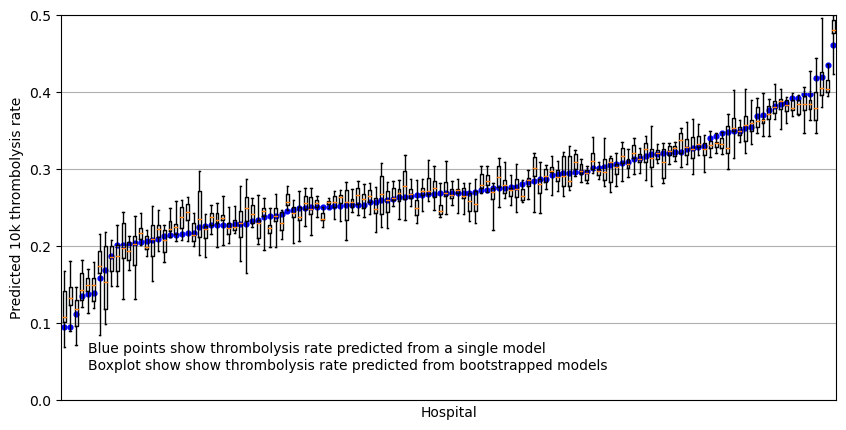

In [15]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
single_fit_values = summary.loc[order]['single fit']
x = np.arange(len(single_fit_values)) + 1
ax.scatter(x, single_fit_values, c='b', s=12)
ax.boxplot(split_thrombolysis_10k_rates.loc[order].T, whis=999)
ax.set_xlabel('Hospital')
ax.set_ylabel('Predicted 10k thrombolysis rate')
ax.set_ylim(0, 0.5)
ax.set_xticks([])
text = 'Blue points show thrombolysis rate predicted from a single model\nBoxplot show show thrombolysis rate predicted from bootstrapped models'
ax.text(5, 0.04, text)
ax.grid()
plt.show()

Plot mean and standard deviation

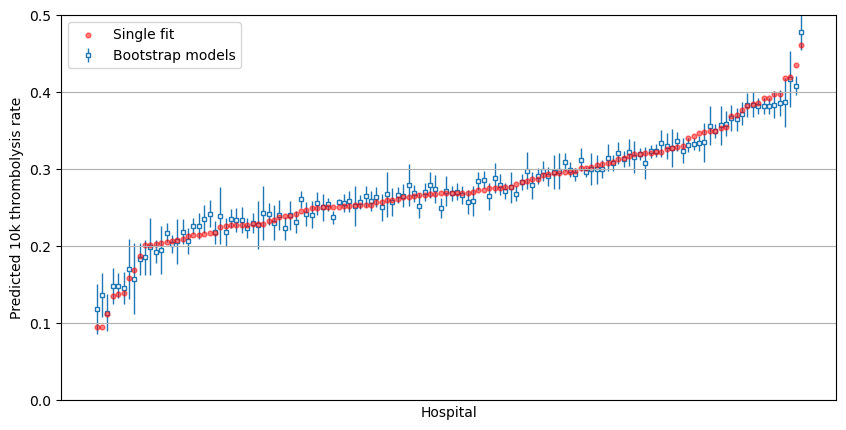

In [16]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
single_fit_values = summary.loc[order]['single fit']
x = np.arange(len(single_fit_values)) + 1


ax.errorbar(x, 
    summary.loc[order]['mean'], 
    yerr=(summary.loc[order]['std']),
    lw=1, ls='', marker='s', markersize=2.5, mfc='w',
    label='Bootstrap models',
    zorder=0)

ax.scatter(x, single_fit_values, c='r', s=12, alpha=0.5, label='Single fit', zorder=1)

ax.set_xlabel('Hospital')
ax.set_ylabel('Predicted 10k thrombolysis rate')
ax.set_ylim(0, 0.5)
ax.set_xticks([])
ax.legend()
ax.grid()
plt.show()

## Create bootstrap sampled training sets using Bayesian bootstrapping

See: https://towardsdatascience.com/the-bayesian-bootstrap-6ca4a1d45148

In [17]:
N = len(train)
models = []
all_predictions = []

for i in range(splits):
    # Get weights
    bayesian_weights = np.random.dirichlet(alpha=np.ones(N)*1, size=1)[0] * N

    # Get X and y
    X_train = train.drop('Thrombolysis', axis=1)
    X_test = test.drop('Thrombolysis', axis=1)
    y_train = train['Thrombolysis']
    y_test = test['Thrombolysis']

    # One hot encode hospitals
    X_train_hosp = pd.get_dummies(X_train['Stroke team'], prefix = 'team')
    X_train = pd.concat([X_train, X_train_hosp], axis=1)
    X_train.drop('Stroke team', axis=1, inplace=True)
    X_test_hosp = pd.get_dummies(X_test['Stroke team'], prefix = 'team')
    X_test = pd.concat([X_test, X_test_hosp], axis=1)
    X_test.drop('Stroke team', axis=1, inplace=True)  

    # Define and fit model
    model = XGBClassifier(verbosity=0, seed=42+i, learning_rate=0.5)
    model.fit(X_train, y_train, sample_weight=bayesian_weights)
    models.append(model)

    # Get predicted probabilities and class
    y_probs = model.predict_proba(X_test)[:,1]
    all_predictions.append(y_probs)
    y_pred = y_probs > 0.5

    # Show accuracy
    accuracy = np.mean(y_pred == y_test)
    print (f'Accuracy set {i}: {accuracy:.3f}')

Accuracy set 0: 0.840
Accuracy set 1: 0.844
Accuracy set 2: 0.839
Accuracy set 3: 0.841
Accuracy set 4: 0.836
Accuracy set 5: 0.840
Accuracy set 6: 0.836
Accuracy set 7: 0.840
Accuracy set 8: 0.841
Accuracy set 9: 0.841


Calculate mean standard deviation of bootstrap replicates for indiviial patient predictions.

In [18]:
all_predictions = np.array(all_predictions)
prediction_std = all_predictions.std(axis=0)
mean_std = prediction_std.mean()
print(f'Mean standard deviation of bootstrap replicates {mean_std:0.3f}')

Mean standard deviation of bootstrap replicates 0.050


### Pass 10k cohort through all hospital models and get thrombolysis rate

For each hospital, set all of the 10k patients in the test set as attending that hospital, and calculate the thrombolysis rate. This will give a thrombolysis rate for each hospital with patient variation removed, and only hospital factors remaining.

In [19]:
# Set up lists for split results
split_thrombolysis_10k_rates = []
split_individual_results = []

# Get list of hopsitals
hospitals = list(set(train['Stroke team']))
hospitals.sort()

for i in range(splits):

    thrombolysis_rate = []
    single_predictions = []

    for hospital in hospitals:

        # Get test data without thrombolysis hospital or stroke team
        X_test_no_hosp = test.drop(['Thrombolysis', 'Stroke team'], axis=1)

        # Copy hospital dataframe and change hospital ID (after setting all to zero)
        X_test_adjusted_hospital = X_test_hosp.copy()
        X_test_adjusted_hospital.loc[:,:] = 0
        team = "team_" + hospital
        X_test_adjusted_hospital[team] = 1

        X_test_adjusted = pd.concat(
            [X_test_no_hosp, X_test_adjusted_hospital], axis=1)
                
        # Get predicted probabilities and class
        y_probs = models[i].predict_proba(X_test_adjusted)[:,1]
        y_pred = y_probs > 0.5
        thrombolysis_rate.append(y_pred.mean())
        
        # Save predictions
        single_predictions.append(y_pred * 1)
    
    # Convert individual predictions (a list of arrays) to a NumPy array, and transpose
    patient_results = np.array(single_predictions).T
    # Convert to DataFrame
    patient_results = pd.DataFrame(patient_results)
    split_individual_results.append(patient_results)

    # Get thrombolysis rate
    thrombolysis_by_hosp = pd.DataFrame(index=hospitals)
    thrombolysis_by_hosp['Thrombolysis rate'] = thrombolysis_rate
    split_thrombolysis_10k_rates.append(thrombolysis_by_hosp)

Sort by hospital 10k thrombolysis rate.

In [20]:
# Concatenate results into a dataframe
split_thrombolysis_10k_rates = pd.concat(split_thrombolysis_10k_rates,axis=1)
split_thrombolysis_10k_rates.head()

,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate,Thrombolysis rate
AGNOF1041H,0.3173,0.3082,0.2940,0.2993,0.3251,0.2966,0.2737,0.3322,0.2948,0.2652
AKCGO9726K,0.3208,0.3201,0.3035,0.3216,0.3243,0.3399,0.3182,0.3269,0.3442,0.3395
AOBTM3098N,0.1960,0.2280,0.2020,0.1958,0.2135,0.2264,0.2054,0.2031,0.2199,0.2194
APXEE8191H,0.2462,0.2801,0.2650,0.2825,0.2594,0.2687,0.2942,0.3020,0.2821,0.2937
ATDID5461S,0.2928,0.2831,0.2928,0.2881,0.2984,0.2807,0.3008,0.3401,0.2807,0.3127


In [21]:
summary = split_thrombolysis_10k_rates.T.describe()
summary = summary.T
summary['single fit'] = single_fit_thrombolysis_10k_rate

# Add confidence limits
alpha = 0.95
length = len(split_thrombolysis_10k_rates)
loc = split_thrombolysis_10k_rates.mean(axis=1)
scale = split_thrombolysis_10k_rates.std(axis=1)
confidence = stats.t.interval(alpha, length, loc, scale)
summary['lower 95'] = loc - confidence[0]
summary['upper 95'] = confidence[1] - loc
summary['std'] = scale

# Identify order in ascending 10k thrombolysis rate
order = list(summary.sort_values('single fit').index)

Calculate mean standard deviation of bootstrap replicates for 10k thrombolysis rates.

In [22]:
mean_std = summary['std'].mean()
print(f'Mean standard deviation of bootstrap replicates {mean_std:0.3f}')

Mean standard deviation of bootstrap replicates 0.016


Plot boxplot

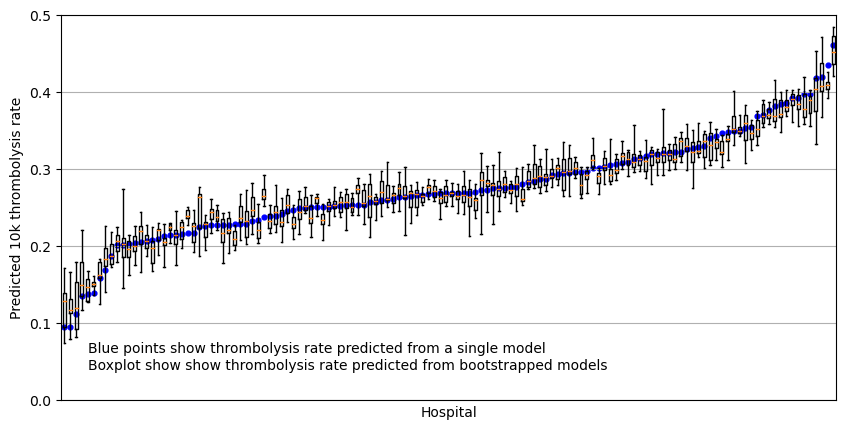

In [23]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
single_fit_values = summary.loc[order]['single fit']
x = np.arange(len(single_fit_values)) + 1
ax.scatter(x, single_fit_values, c='b', s=12)
ax.boxplot(split_thrombolysis_10k_rates.loc[order].T, whis=999)
ax.set_xlabel('Hospital')
ax.set_ylabel('Predicted 10k thrombolysis rate')
ax.set_ylim(0, 0.5)
ax.set_xticks([])
text = 'Blue points show thrombolysis rate predicted from a single model\nBoxplot show show thrombolysis rate predicted from bootstrapped models'
ax.text(5, 0.04, text)
ax.grid()
plt.show()

Plot mean and standard deviation

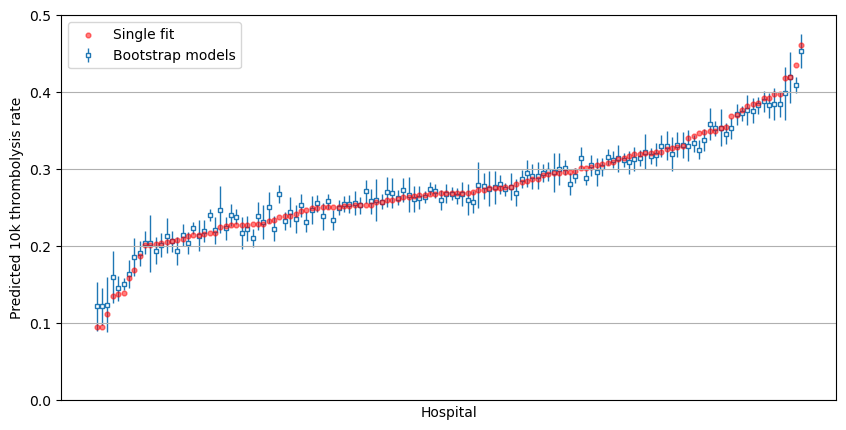

In [24]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
single_fit_values = summary.loc[order]['single fit']
x = np.arange(len(single_fit_values)) + 1


ax.errorbar(x, 
    summary.loc[order]['mean'], 
    yerr=(summary.loc[order]['std']),
    lw=1, ls='', marker='s', markersize=2.5, mfc='w',
    label='Bootstrap models',
    zorder=0)

ax.scatter(x, single_fit_values, c='r', s=12, alpha=0.5, label='Single fit', zorder=1)

ax.set_xlabel('Hospital')
ax.set_ylabel('Predicted 10k thrombolysis rate')
ax.set_ylim(0, 0.5)
ax.set_xticks([])
ax.legend()
ax.grid()
plt.show()